In [1]:
import numpy as np
import torch
import time

import sys
sys.path.insert(1, 'C:/Users/philh/Notebooks/jmp_solver/')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [3]:
# Tests
# a=-1.0, b=1.0, {C=0.1, A=0.1, beta=30, omega=20pi, deg=100}, model(n=100, p=np.inf)
# a=-1.0, b=1.0, {C=0.1, A=0.1, beta=5, omega=26.5pi, deg=100}, model(n=100, p=np.inf)

### 1D Poisson Equation
Let $\Omega = (-1, 1), A, C, u_a, u_b, \omega, \beta \in \mathbb{R}$:

$$
{\large \begin{cases}
    \Delta u + f = 0, x \in \Omega \\
    u(a) = u_a, \ u(b) = u_b,
\end{cases}}$$

with
$${\large f(x) = C \cdot (A \omega^2 sin(\omega x) + 2 \beta^2 (sinh(\beta x) \ / \ cosh(\beta x)^3))}$$

In [18]:
rect = np.array([[-1.0, 1.0]])

omega = 5*np.pi
A = 0.1
beta = 1
C = 0.1

def f(x):
    return C*(A*omega**2*np.sin(omega*x) + 
         (2*beta**2)*(np.sinh(beta*x)/np.cosh(beta*x)**3))

In [31]:
# Sobolev Cubature
diffeo = hyper_rect(*rect)
sob = Sobolev(deg=100, diffeo=diffeo)
dx2 = torch.tensor(sob.diff.diffs(np.array([[2]])))[0]

In [32]:
# Surrogate Model
model = surrogates.Polynomial(
    n=100,
    p=np.inf, 
    dim=1, 
    scale=[np.max(np.abs(rect))])
model.set_weights_val(0.0)
model_deg = model.get_deg()

### Ground Truth
$${\large u(x) = A sin(\omega x) + tanh(\beta x)}$$

In [33]:
def gt(x):
    return C*(A*np.sin(omega*x)+np.tanh(beta*x))

### Gradient Flow

In [34]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# For that use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [ ]:
# Sobolev Order
sob.set_s(-1)

In [35]:
# Data
xs_plt, xs = sob.get_xs()
x_bndr = rect[0]

dmn = model.data_axis(xs[0]).T
bndr = model.data_axis(x_bndr).T

u_bndr = torch.tensor([gt(x_bndr[0]), gt(x_bndr[1])])
fX = torch.tensor(f(xs[0]))

# Sobolev Metric
metric = sob.metric(weak=True)

# Formulation
K = dx2
eq = lambda u: matmul(K, u)+fX
crit_dmn = lambda u: sob.loss(eq(u), weak=True)
crit_bndr = lambda u: torch.mean((u-u_bndr)**2)
grad_dmn = lambda u: 2*matmul(K.T, metric(eq(u)))
grad_bndr = lambda u: 2*(u-u_bndr)

# Testing
test_xs = np.linspace(x_bndr[0], x_bndr[1], 1001)
data = model.data_axis(test_xs).T

In [36]:
solver = Solver(
    dmns=[dmn, bndr],
    crits=[crit_dmn, crit_bndr],
    model=model,
    test_axes=[test_xs],
    grads=[grad_dmn, grad_bndr],
    gt=gt,
    data=data)

In [37]:
# Accuracy Test of Formulation
crit_dmn(torch.tensor(gt(xs[0])))

tensor(7.2119e-22)

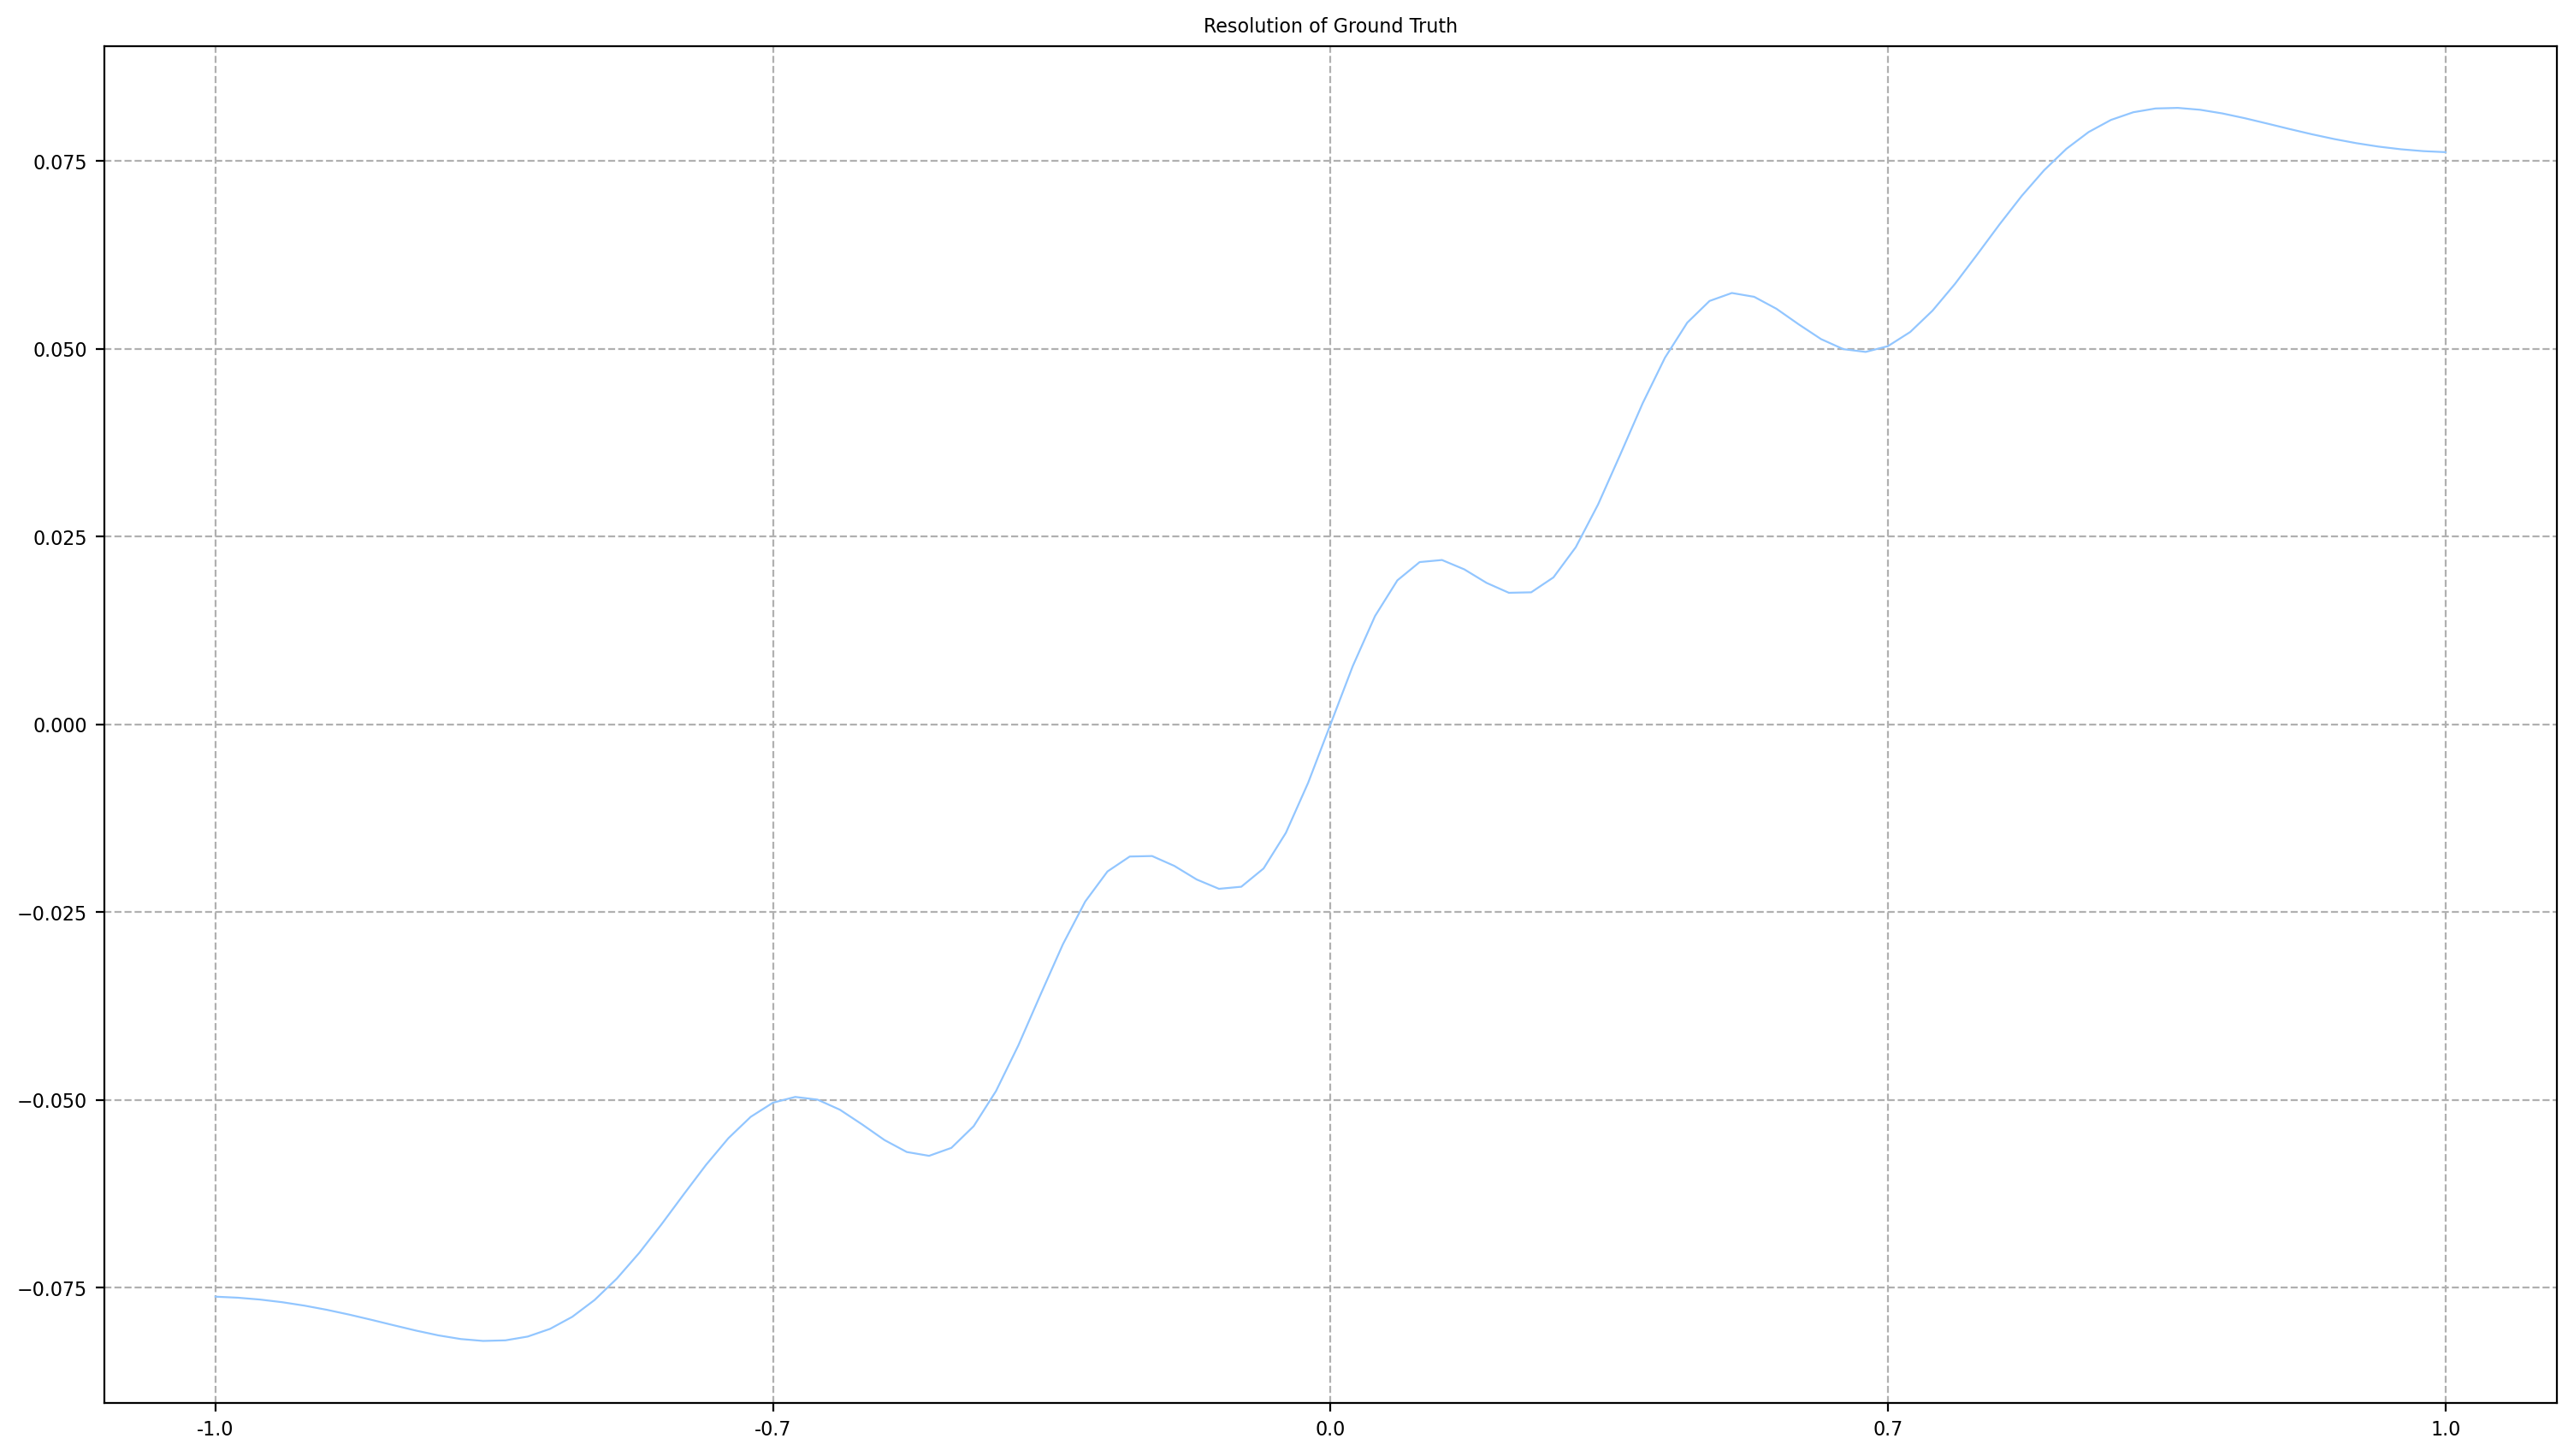

In [38]:
solver.plot1d(gt(xs_plt[0]), xs_plt[0], title="Resolution of Ground Truth")#, file_name="gt_resolution_poisson1d")

In [40]:
# Analytic Gradient Flow
start = time.time()
KsK = 2*matmul(dmn.T, K.T, metric(matmul(K, dmn)))+2*matmul(bndr.T, bndr)
Ksf = 2*matmul(dmn.T, K.T, metric(-fX))+2*matmul(bndr.T, u_bndr)
w = matmul(KsK.inverse(), Ksf)
model.set_weights(w)
end = time.time()
print('time consumption: %.2fs' % (end-start))

time consumption: 0.01s


In [40]:
# Discrete Gradient Flow
optimizer = torch.optim.LBFGS(solver.model.parameters())
solver.train(100, 10, optim=optimizer)
print('time consumption: %.2fs' % solver.get_time())

epoch 10: loss = 0.0000000003309570
epoch 20: loss = 0.0000000003309570
epoch 30: loss = 0.0000000003309570
epoch 40: loss = 0.0000000003309570
epoch 50: loss = 0.0000000003309570
epoch 60: loss = 0.0000000003309570
epoch 70: loss = 0.0000000003309570
epoch 80: loss = 0.0000000003309570
epoch 90: loss = 0.0000000003309570
epoch 100: loss = 0.0000000003309570
time consumption: 1.08s


### Benchmarks

In [41]:
# Evaluate
_, _ = solver.eval()

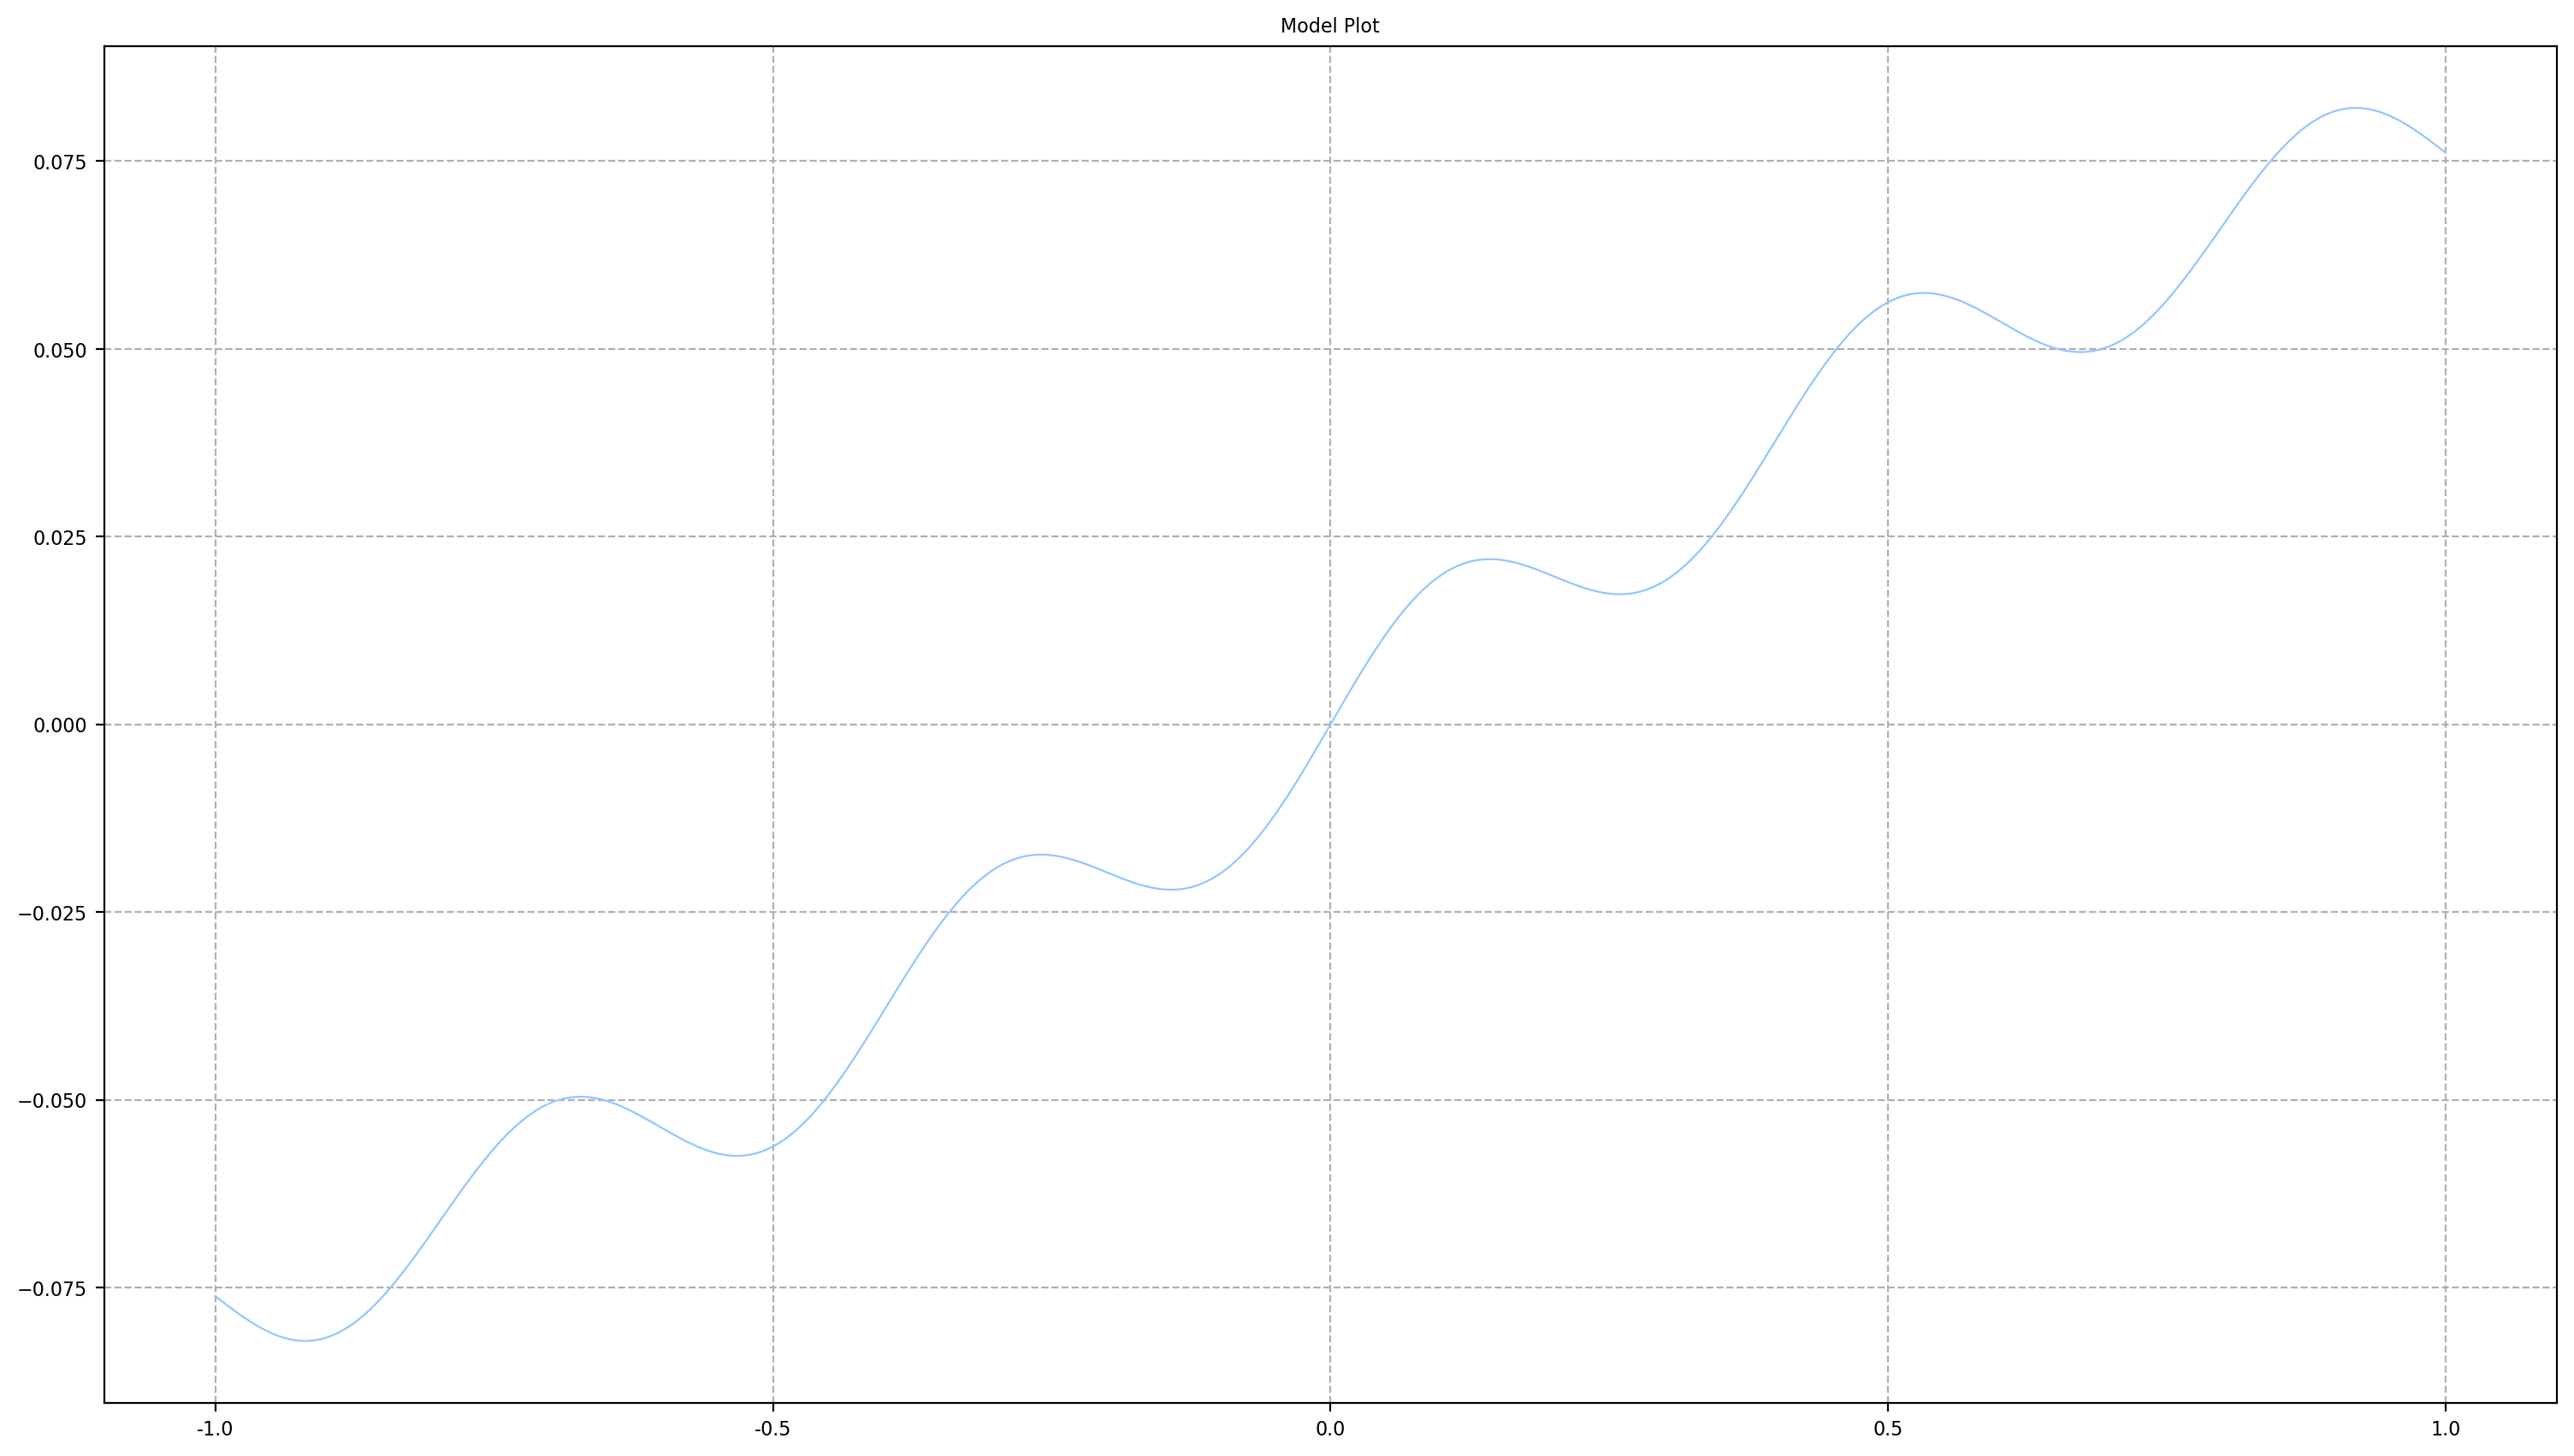

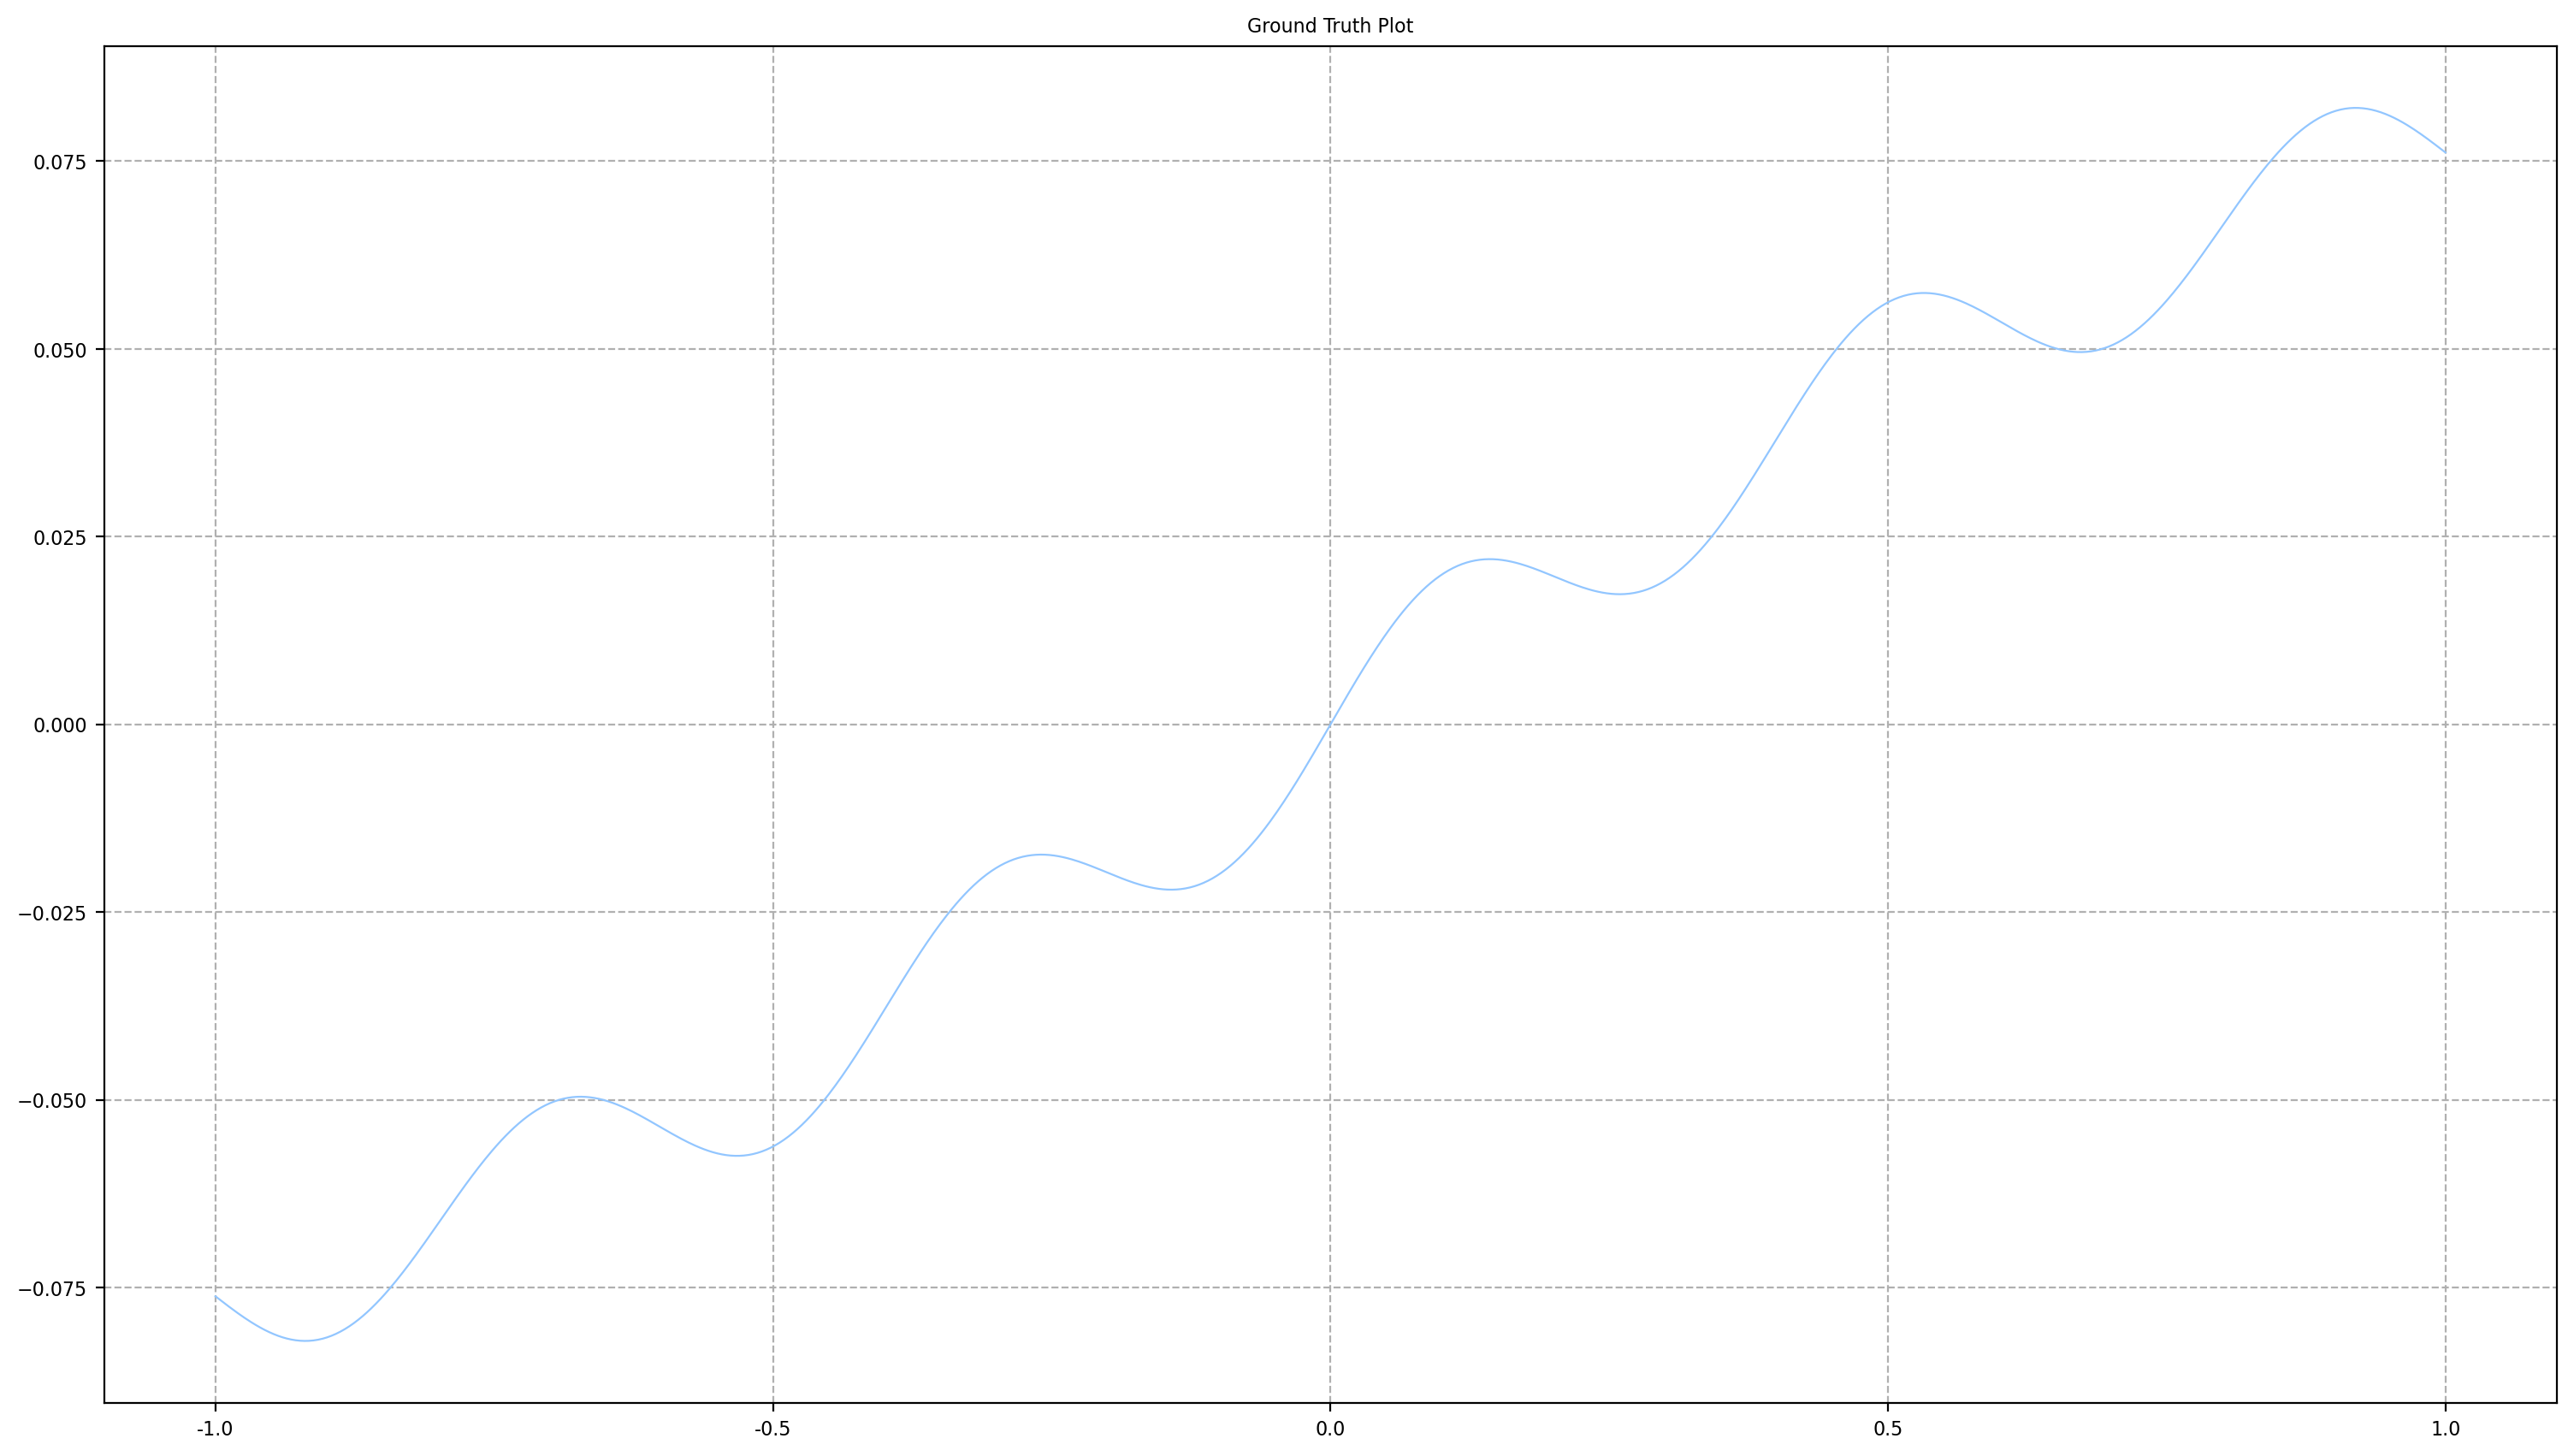

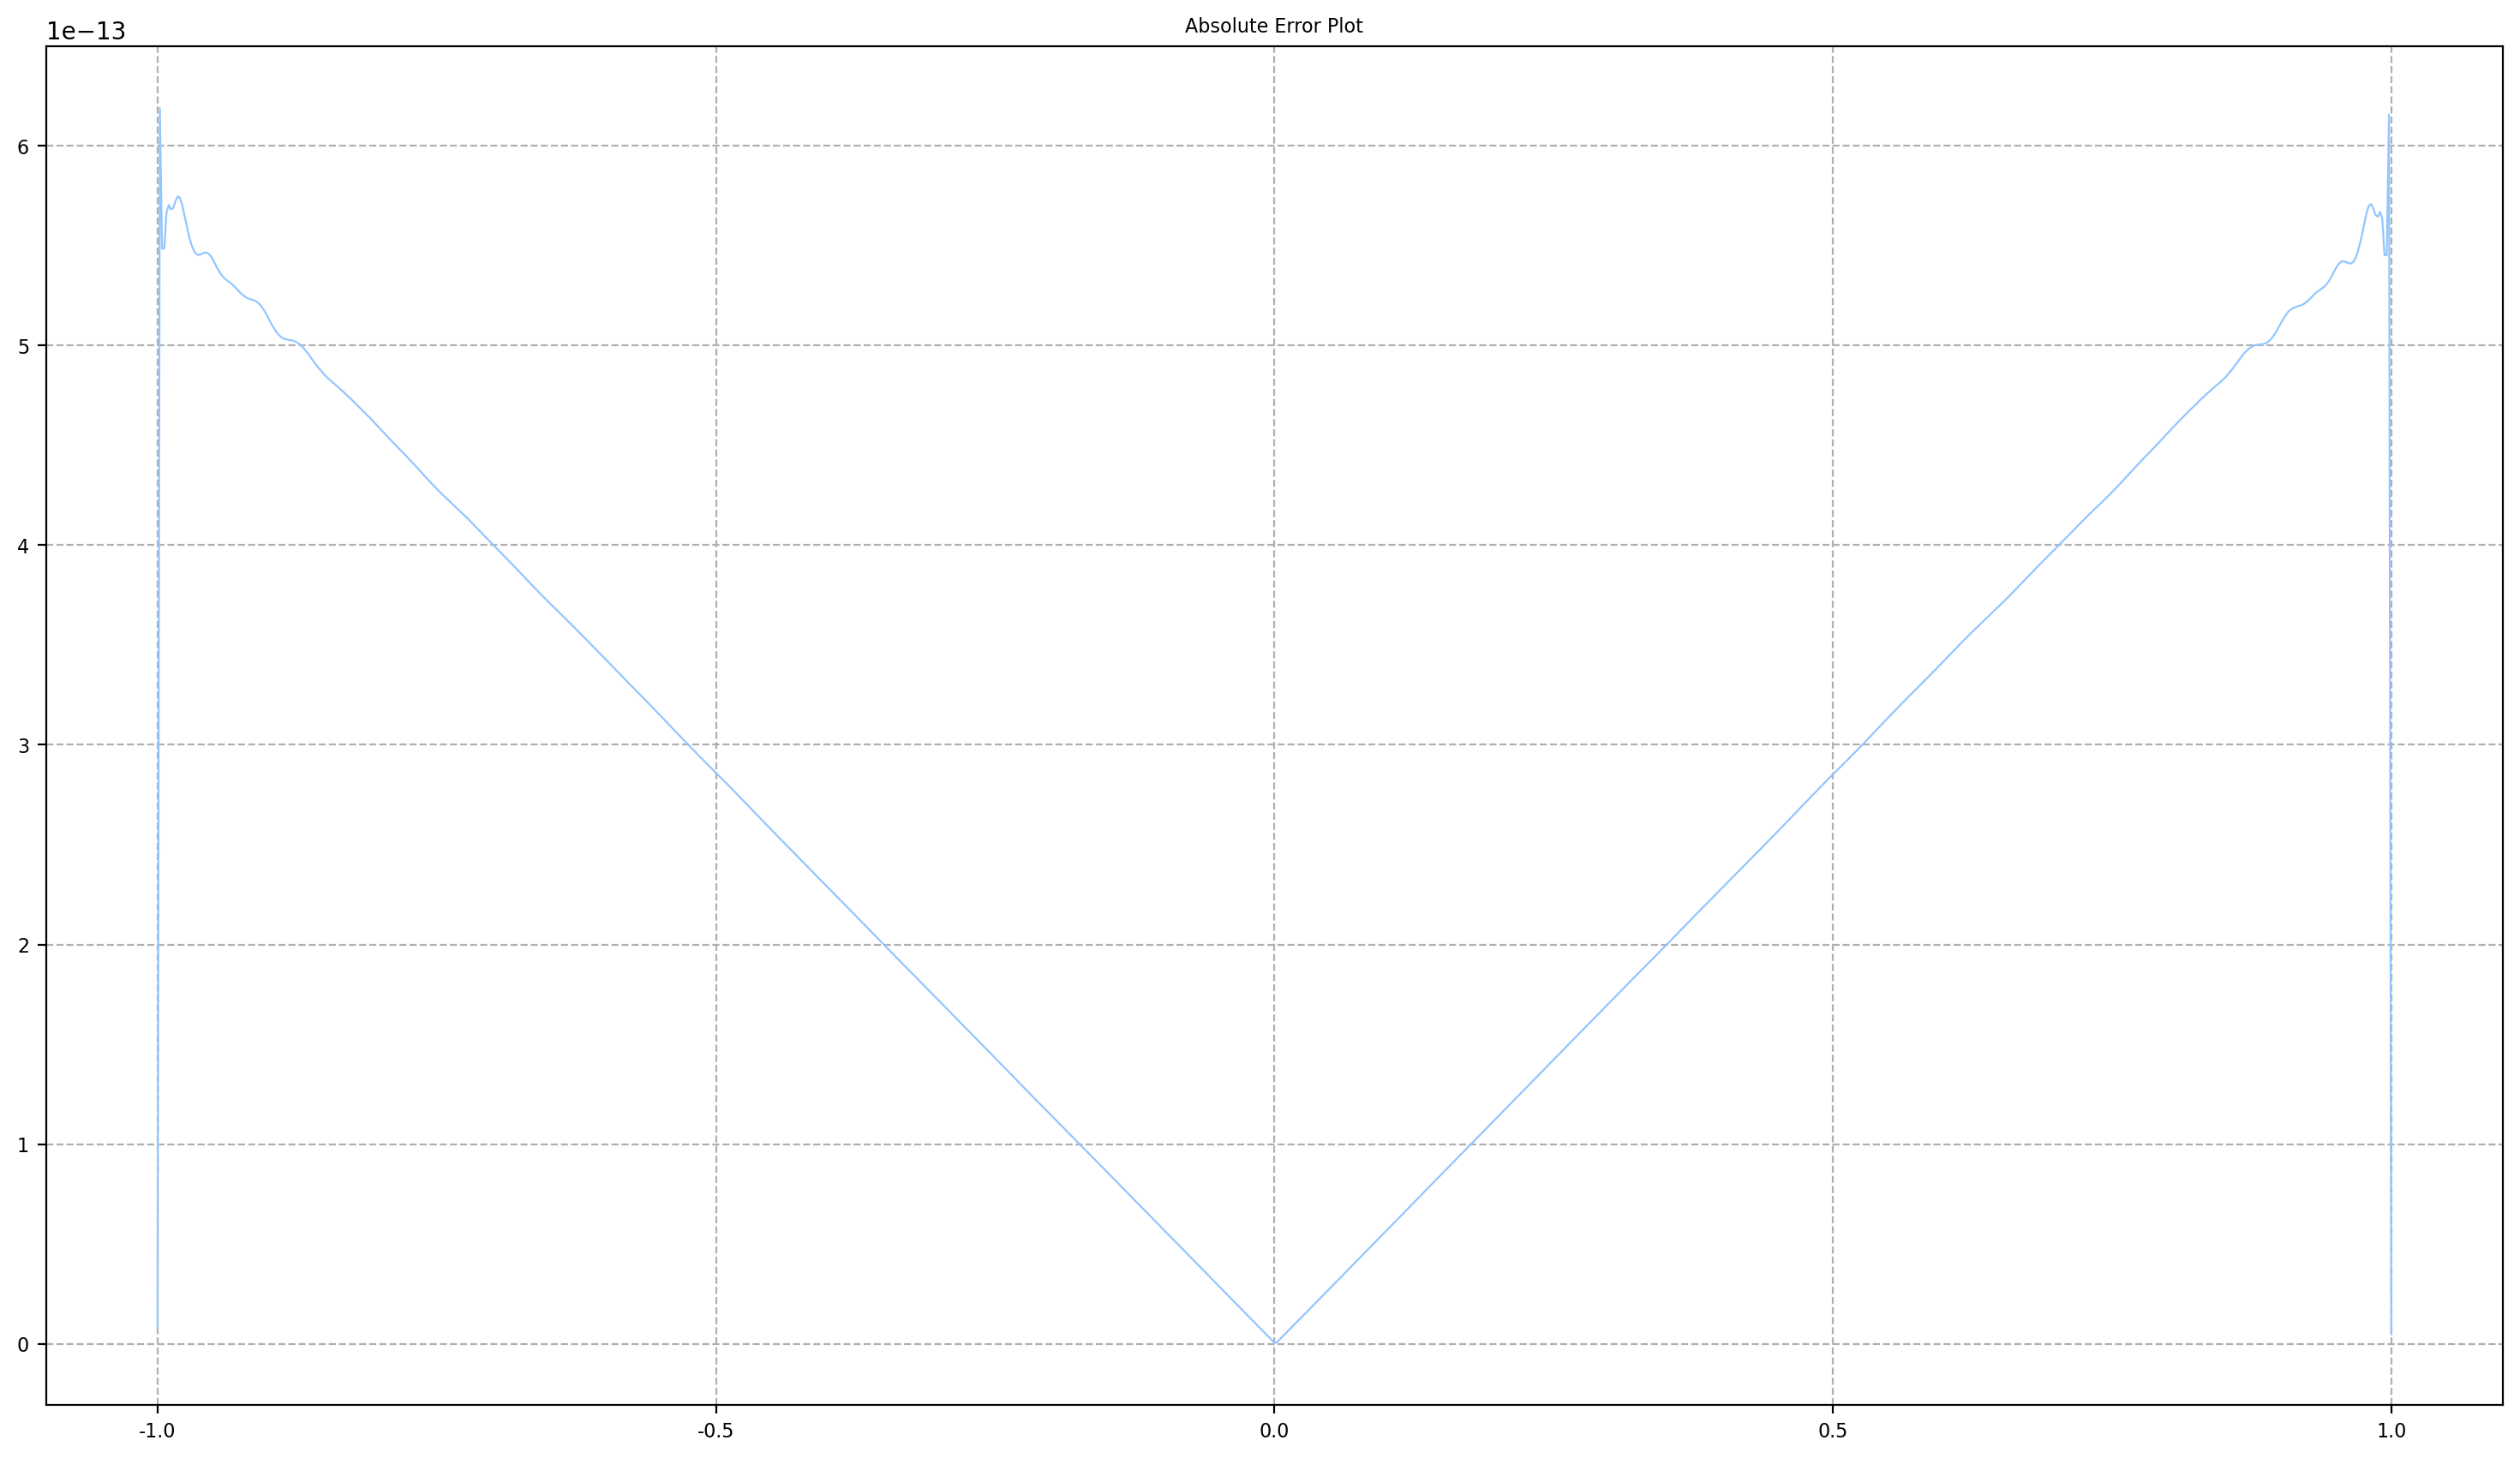

In [42]:
# Plots
suffix=None#"poisson1d"
solver.plot_model(suffix=suffix)
solver.plot_gt(suffix=suffix)
solver.plot_abs_err(suffix=suffix)

In [43]:
# Errors
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

L1  Error: 2.844225197326205e-13
L2  Error: 3.286934474699686e-13
Max Error: 6.18935458440717e-13
